In [2]:
import quandl
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# get adjusted closeing prices of 5 selected companies with Quandl
# quandl.ApiConfig.api_key = '_p6ZbKivPwpkjR-JX7CP'
# selected = ['GOOGL', 'AMD', 'AMZN', 'NFLX', 'F']
# data = quandl.get_table('WIKI/PRICES', ticker = selected,
#                        qopts = {'columns': ['date', 'ticker', 'adj_close']},
#                        date = {'gte': '2015-1-1', 'lte': '2020-2-1'}, paginate = True)

assets =  ['URTH', 'ICLN', 'GLD', 'BLK', 'GOOGL'] 


table = pd.DataFrame()  

for stock in assets:
    table[stock] = web.DataReader(stock, data_source='yahoo',
                               start='2015-1-1' , end='2020-4-19')['Adj Close']
table.head()

,URTH,ICLN,GLD,BLK,GOOGL
Date,,,,,
2015-01-02,64.299652,8.600410,114.080002,311.234619,529.549988
2015-01-05,62.792004,8.415173,115.800003,303.181763,519.460022
2015-01-06,61.957409,8.397531,117.120003,298.470459,506.640015
2015-01-07,62.585594,8.476917,116.430000,304.787170,505.149994
2015-01-08,63.976578,8.679800,115.940002,308.346771,506.910004


In [4]:
# reorganize pulled data by setting date as index with columns of tickers and their corresponding adjusted prices
# clean = data.set_index('Date')
# table = data.pivot(columns='ticker')
# table.head()

In [5]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# set number of combinations for imaginary portfolios
num_assets = len(assets)
num_portfolios = 100000

# populate the empty lists with each portfolio's returns, risks and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights / np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    sharpe_ratio.append(sharpe)
    
# a dictionary for returns and risk values of each portfolio
portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

# extend additional dictionary to accomodate each ticker and weight in the portfolio
for counter, symbol in enumerate(assets):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe for the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' weight' for stock in assets]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,Sharpe Ratio,URTH weight,ICLN weight,GLD weight,BLK weight,GOOGL weight
0,0.091451,0.184992,0.494350,0.264913,0.269716,0.118400,0.277461,0.069511
1,0.097689,0.129529,0.754185,0.157700,0.174238,0.417382,0.054729,0.195951
2,0.103205,0.170754,0.604408,0.379212,0.213221,0.126882,0.025953,0.254732
3,0.104179,0.190222,0.547673,0.244000,0.253156,0.080809,0.241412,0.180622
4,0.089822,0.174110,0.515891,0.256839,0.198587,0.189438,0.314788,0.040349


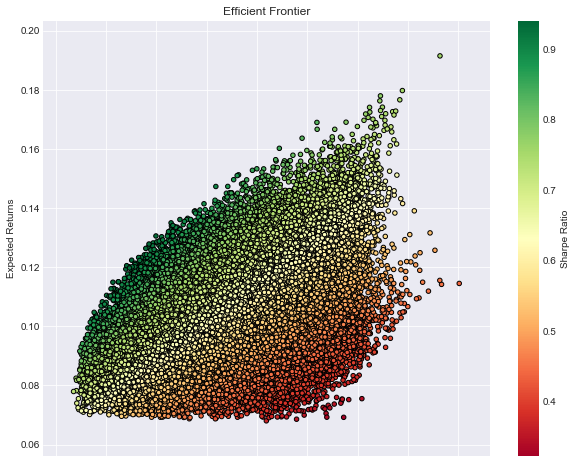

In [6]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c = 'Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10,8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

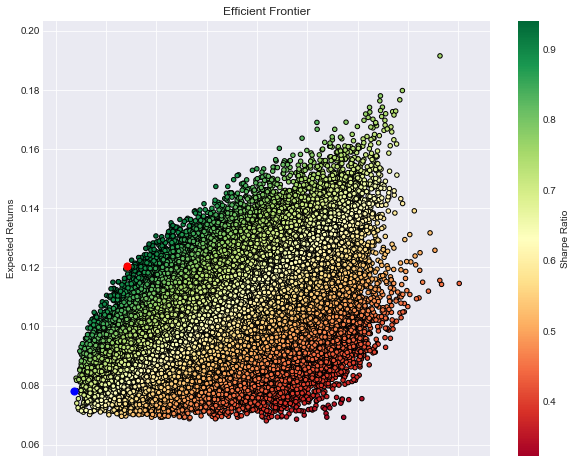

In [7]:
# find minimum Volatility and maximum Sharpe Ratio in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min and max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot efficient frontier, minimum volatility and maximum sharpe ratio values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='.', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='.', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [8]:
# print the details of the two special portfolios
print("Minimum Variance Portfolio:")
print(min_variance_port.T)
print()
print("Maximum Sharpe Ratio Portfolio:")
print(sharpe_portfolio.T)

Minimum Variance Portfolio:
                 52922
Returns       0.077951
Volatility    0.107060
Sharpe Ratio  0.728101
URTH weight   0.263713
ICLN weight   0.018193
GLD weight    0.646886
BLK weight    0.017716
GOOGL weight  0.053492

Maximum Sharpe Ratio Portfolio:
                 72407
Returns       0.120509
Volatility    0.128181
Sharpe Ratio  0.940144
URTH weight   0.026963
ICLN weight   0.006941
GLD weight    0.540568
BLK weight    0.064646
GOOGL weight  0.360883
